## Analyzing the Global Correlation between SZA Drifts and Reflectance Values
### Jianing Fang (jf3423@columbia.edu)

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import multiprocessing as mp
from tqdm import tqdm
from scipy.signal import detrend
from scipy.stats import linregress
import rioxarray as rxr
import torch
from copy import copy, deepcopy
import matplotlib
import cartopy 
import cartopy.crs as ccrs
import warnings
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from scipy.io import loadmat

rcParams['font.family'] = 'Inter'
rcParams['font.size'] = 12
rcParams['figure.figsize'] = [5.0, 5.0]
rcParams['figure.dpi'] = 300
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'


In [2]:
AVHRR_FILE_DIR = "/AVHRR_16day/" # calibrated AVHRR reflectance
MODIS_FILE_DIR = "/MCD43C4.006_16day/" # calibrated MODIS reflectance
VECTOR_DIR="../../data/vector/" # vector dataset directory

In [3]:
def get_file_list(product_dir):
    filelist=[]
    for year in sorted(os.listdir(product_dir)):
        for year_file in sorted(os.listdir(os.path.join(product_dir, year))):
            filelist.append(os.path.join(product_dir, year, year_file))
    return filelist

In [4]:
def downsample_raster_data(raster_data, weight, bin_size=10, count_threshold = 0.5):
    with torch.no_grad():
        conv = torch.nn.Conv2d(1, 1, (bin_size,bin_size), bin_size, bias=False)
        conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
        raster_data_tensor = torch.tensor(raster_data).expand(1, raster_data.shape[0], raster_data.shape[1]).float()
        weight_tensor = torch.tensor(weight).expand(1, 3600, 7200).float()
        weighted_raster_data_tensor = raster_data_tensor * weight_tensor
        weighted_count_tensor = np.invert(torch.isnan(raster_data_tensor)).type(torch.float) * weight_tensor
        weighted_raster_data_tensor[torch.isnan(raster_data_tensor)] = 0.0
        
        downsampled = conv(weighted_raster_data_tensor).numpy()[0]
        downsampled_weight = conv(weight_tensor).numpy()[0]
        downsampled_weighted_count= conv(weighted_count_tensor).numpy()[0]

    downsampled = downsampled / downsampled_weighted_count
    downsampled[downsampled_weighted_count < downsampled_weight * count_threshold] = np.nan
    return downsampled

In [5]:
LCSIF_DIR="../../data/processed/LCSIF_v2"
LCSIF_FILE_LIST=np.array(get_file_list(LCSIF_DIR)[0:456]).reshape(-1, 24) # LCSIF_v2 files

In [6]:
AVHRR_FILE_LIST = np.array(get_file_list(AVHRR_FILE_DIR)[0:456]).reshape(-1, 24) # AHHRR reflectance files
MODIS_FILE_LIST = np.array(get_file_list(MODIS_FILE_DIR)[24:456]).reshape(-1, 24) # MODIS reflectance files
area_weight=xr.open_dataset(os.path.join(VECTOR_DIR, "CMG_0.05Degree_Area_WGS84.nc")).area.values # area weight to compute area weighted mean
NAN_MASK = xr.open_dataset("../../data/processed/LCSIF_LCREF_MASK.nc").LCSIF_LCREF_MASK.values # data mask to mask out pixels that are missing during the AVHRR period to ensure consistent spatial coverage.

In [7]:
def extract_annual_mean_list(variable_name, file_list, annual_mean_list, NAN_MASK):
    for YEAR in tqdm(np.array(file_list).reshape(-1,24)):
        year_list=[]
        for i in range(12):
            first_half_month = xr.open_dataset(YEAR[i*2])[variable_name].values[0]
            first_half_month[NAN_MASK]=np.nan
            second_half_month = xr.open_dataset(YEAR[i*2 + 1])[variable_name].values[0]
            second_half_month[NAN_MASK]=np.nan
            year_list.append(np.nanmean(np.stack([first_half_month, second_half_month]), axis=0))
        year_stack = np.stack(year_list)
        year_mean = np.nanmean(year_stack, axis=0)
        year_weighted = np.nansum(year_mean * area_weight) / np.nansum(area_weight[np.invert(np.isnan(year_mean * area_weight))])
        annual_mean_list.append(year_weighted)

In [ ]:
red_avhrr_annual_mean_list=[]
nir_avhrr_annual_mean_list=[]

extract_annual_mean_list("red_modvalml_filled4", AVHRR_FILE_LIST, red_avhrr_annual_mean_list, NAN_MASK)
extract_annual_mean_list("nir_modvalml_filled4", AVHRR_FILE_LIST, nir_avhrr_annual_mean_list, NAN_MASK)

In [46]:
red_avhrr_annual_normalized_anomaly = (red_avhrr_annual_mean_list - np.mean(red_avhrr_annual_mean_list)) / np.mean(red_avhrr_annual_mean_list)
red_avhrr_annual_normalized_anomaly_detrend = detrend(red_avhrr_annual_normalized_anomaly)

nir_avhrr_annual_normalized_anomaly = (nir_avhrr_annual_mean_list - np.mean(nir_avhrr_annual_mean_list)) / np.mean(nir_avhrr_annual_mean_list)
nir_avhrr_annual_normalized_anomaly_detrend = detrend(nir_avhrr_annual_normalized_anomaly)

sza_avhrr_annual_normalized_anomaly = (sza_avhrr_annual_mean_list - np.mean(sza_avhrr_annual_mean_list)) / np.mean(sza_avhrr_annual_mean_list)
sza_avhrr_annual_normalized_anomaly_detrend = detrend(sza_avhrr_annual_normalized_anomaly)


red_modis_annual_normalized_anomaly = (red_modis_annual_mean_list - np.mean(red_modis_annual_mean_list)) / np.mean(red_modis_annual_mean_list)
red_modis_annual_normalized_anomaly_detrend = detrend(red_modis_annual_normalized_anomaly)

nir_modis_annual_normalized_anomaly = (nir_modis_annual_mean_list - np.mean(nir_modis_annual_mean_list)) / np.mean(nir_modis_annual_mean_list)
nir_modis_annual_normalized_anomaly_detrend = detrend(nir_modis_annual_normalized_anomaly)

sza_modis_annual_normalized_anomaly = (sza_modis_annual_mean_list - np.mean(sza_modis_annual_mean_list)) / np.mean(sza_modis_annual_mean_list)
sza_modis_annual_normalized_anomaly_detrend = detrend(sza_modis_annual_normalized_anomaly)


In [48]:
red_combined_annual_mean_list = np.concatenate([red_avhrr_annual_mean_list, red_modis_annual_mean_list])
nir_combined_annual_mean_list = np.concatenate([nir_avhrr_annual_mean_list, nir_modis_annual_mean_list])
sza_combined_annual_mean_list = np.concatenate([sza_avhrr_annual_mean_list, sza_modis_annual_mean_list])

In [49]:
red_combined_annual_normalized_anomaly = (red_combined_annual_mean_list - np.mean(red_combined_annual_mean_list)) / np.mean(red_combined_annual_mean_list)
red_combined_annual_normalized_anomaly_detrend = detrend(red_combined_annual_normalized_anomaly)

nir_combined_annual_normalized_anomaly = (nir_combined_annual_mean_list - np.mean(nir_combined_annual_mean_list)) / np.mean(nir_combined_annual_mean_list)
nir_combined_annual_normalized_anomaly_detrend = detrend(nir_combined_annual_normalized_anomaly)

sza_combined_annual_normalized_anomaly = (sza_combined_annual_mean_list - np.mean(sza_combined_annual_mean_list)) / np.mean(sza_combined_annual_mean_list)
sza_combined_annual_normalized_anomaly_detrend = detrend(sza_combined_annual_normalized_anomaly)


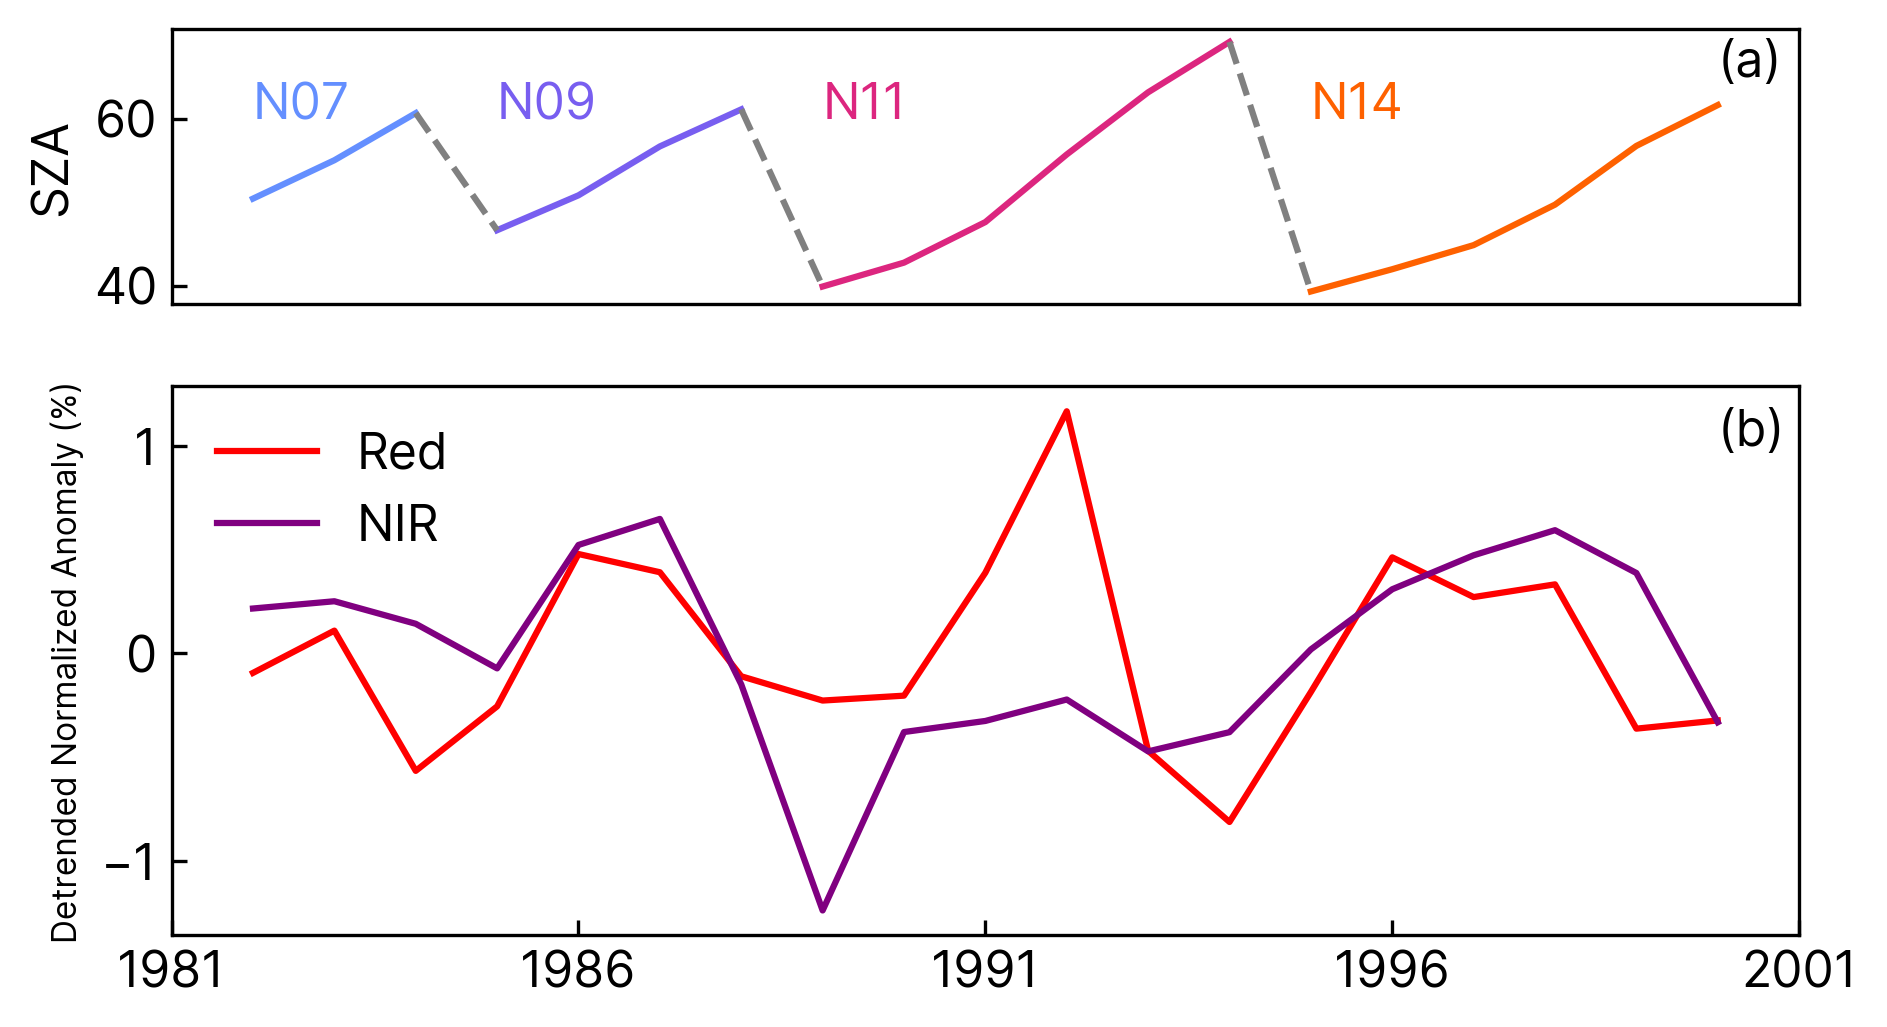

In [143]:
f, (ax1, ax2) = plt.subplots(2, 1,  gridspec_kw={'height_ratios': [1,2]}, figsize=(7,4))

ax1.plot(np.arange(1982, 2001)[0:3], sza_avhrr_annual_mean_list[0:3], c="#648FFF", label="N07")
ax1.text(1982, 60, "N07", c="#648FFF")
ax1.plot(np.arange(1982, 2001)[3:7], sza_avhrr_annual_mean_list[3:7], c="#785EF0", label="N09")
ax1.text(1985, 60, "N09", c="#785EF0")
ax1.plot(np.arange(1982, 2001)[7:13], sza_avhrr_annual_mean_list[7:13], c="#DC267F", label="N11")
ax1.text(1989, 60, "N11", c="#DC267F")
ax1.plot(np.arange(1982, 2001)[13:19], sza_avhrr_annual_mean_list[13:19], c="#FE6100", label="N14")
ax1.text(1995, 60, "N14", c="#FE6100")
ax1.plot(np.arange(1982, 2001)[2:4], sza_avhrr_annual_mean_list[2:4], c="grey", linestyle="--")
ax1.plot(np.arange(1982, 2001)[6:8], sza_avhrr_annual_mean_list[6:8], c="grey", linestyle="--")
ax1.plot(np.arange(1982, 2001)[12:14], sza_avhrr_annual_mean_list[12:14], c="grey", linestyle="--")

ax1.set_xticks([])
ax1.set_ylabel("SZA")
ax2.plot(np.arange(1982, 2001), red_avhrr_annual_normalized_anomaly_detrend * 100, c="red", label="Red")
ax2.plot(np.arange(1982, 2001), nir_avhrr_annual_normalized_anomaly_detrend * 100, c="purple", label="NIR")
ax2.set_xticks([1981, 1986, 1991, 1996, 2001], ["1981", "1986", "1991", "1996", "2001"])
ax2.legend(frameon=False)
ax1.set_xlim(1981,2001)
ax2.set_xlim(1981,2001)
ax1.text(2000, 65, "(a)")
ax2.text(2000, 1, "(b)")

ax2.set_ylabel("Detrended Normalized Anomaly (%)", fontsize=8)
plt.savefig("./figs/Global_SZA_Reflectance_Anomaly.png")

In [8]:
def extract_downsampled_spatial_list(variable_name, file_list, spatial_list, NAN_MASK):
    for YEAR in tqdm(np.array(file_list).reshape(-1,24)):
        year_list = []
        for i in range(12):
            first_half_month = xr.open_dataset(YEAR[i*2])[variable_name].values[0]
            first_half_month[NAN_MASK]=np.nan
            second_half_month = xr.open_dataset(YEAR[i*2 + 1])[variable_name].values[0]
            second_half_month[NAN_MASK]=np.nan
            data_array = np.nanmean(np.stack([first_half_month, second_half_month]), axis=0)
            downsampled_data_array = downsample_raster_data(data_array, area_weight)
            year_list.append(downsampled_data_array)
        year_stack = np.stack(year_list)
        year_mean = np.nanmean(year_stack, axis=0)
        spatial_list.append(year_mean)

In [ ]:
sif_avhrr_spatial_list=[]
extract_downsampled_spatial_list("sif_clear_daily", LCSIF_FILE_LIST, sif_avhrr_spatial_list, NAN_MASK)

In [ ]:
red_avhrr_spatial_list=[]
nir_avhrr_spatial_list=[]

extract_downsampled_spatial_list("red_modvalml_filled4", AVHRR_FILE_LIST, red_avhrr_spatial_list, NAN_MASK)
extract_downsampled_spatial_list("nir_modvalml_filled4", AVHRR_FILE_LIST, nir_avhrr_spatial_list, NAN_MASK)

In [11]:
red_avhrr_spatial_array = np.stack(red_avhrr_spatial_list, axis=0)
nir_avhrr_spatial_array = np.stack(nir_avhrr_spatial_list, axis=0)
sif_avhrr_spatial_array = np.stack(sif_avhrr_spatial_list, axis=0)

In [12]:
downsampled_area_weight = downsample_raster_data(area_weight, area_weight)

In [13]:
# This is the AVHRR SZA dataset prepared by Chongya Jiang
TCDR_SZA = loadmat("../../data/TCDR_SZA.mat")["data"][0:19*12]

sza_avhrr_spatial_array = np.nanmean(TCDR_SZA[np.arange(0, 228).reshape(-1, 12), :, :], axis=1)

/tmp/ipykernel_2012682/2115961893.py:3: RuntimeWarning: Mean of empty slice
  sza_avhrr_spatial_array = np.nanmean(TCDR_SZA[np.arange(0, 228).reshape(-1, 12), :, :], axis=1)


In [29]:
red_avhrr_annual_mean_list = []
nir_avhrr_annual_mean_list = []
sif_avhrr_annual_mean_list = []
sza_avhrr_annual_mean_list = []


for i in range(red_avhrr_spatial_array.shape[0]):
    temp_nan_mask = np.isnan(red_avhrr_spatial_array[i, :, :]) | np.isnan(nir_avhrr_spatial_array[i, :, :]) | np.isnan(sif_avhrr_spatial_array[i, :, :]) | np.isnan(sza_avhrr_spatial_array[i, :, :])
    red = copy(red_avhrr_spatial_array[i, :, :])
    red[temp_nan_mask] = np.nan
    nir = copy(nir_avhrr_spatial_array[i, :, :])
    nir[temp_nan_mask] = np.nan
    sif = copy(sif_avhrr_spatial_array[i, :, :])
    sif[temp_nan_mask] = np.nan
    sza = copy(sza_avhrr_spatial_array[i, :, :])
    sza[temp_nan_mask] = np.nan
    
    red_weighted = np.nansum(red * downsampled_area_weight) / np.nansum(downsampled_area_weight[np.invert(np.isnan(red * downsampled_area_weight))])
    red_avhrr_annual_mean_list.append(red_weighted)
    nir_weighted = np.nansum(nir * downsampled_area_weight) / np.nansum(downsampled_area_weight[np.invert(np.isnan(nir * downsampled_area_weight))])
    nir_avhrr_annual_mean_list.append(nir_weighted)
    sif_weighted = np.nansum(sif * downsampled_area_weight) / np.nansum(downsampled_area_weight[np.invert(np.isnan(sif * downsampled_area_weight))])
    sif_avhrr_annual_mean_list.append(sif_weighted)
    sza_weighted = np.nansum(sza * downsampled_area_weight) / np.nansum(downsampled_area_weight[np.invert(np.isnan(sza * downsampled_area_weight))])
    sza_avhrr_annual_mean_list.append(sza_weighted)

In [30]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount.
    Reference: https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    #n     = x.shape[0]
    n = np.sum(np.invert(np.isnan(x.values)) & np.invert(np.isnan(y.values)), axis=0)
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

In [53]:
red_avhrr_annual_normalized_anomaly = (red_avhrr_annual_mean_list - np.mean(red_avhrr_annual_mean_list)) / np.mean(red_avhrr_annual_mean_list)
red_avhrr_annual_normalized_anomaly_detrend = detrend(red_avhrr_annual_normalized_anomaly)

nir_avhrr_annual_normalized_anomaly = (nir_avhrr_annual_mean_list - np.mean(nir_avhrr_annual_mean_list)) / np.mean(nir_avhrr_annual_mean_list)
nir_avhrr_annual_normalized_anomaly_detrend = detrend(nir_avhrr_annual_normalized_anomaly)

sif_avhrr_annual_normalized_anomaly = (sif_avhrr_annual_mean_list - np.mean(sif_avhrr_annual_mean_list)) / np.mean(sif_avhrr_annual_mean_list)
sif_avhrr_annual_normalized_anomaly_detrend = detrend(sif_avhrr_annual_normalized_anomaly)

sza_avhrr_annual_normalized_anomaly = (sza_avhrr_annual_mean_list - np.mean(sza_avhrr_annual_mean_list)) / np.mean(sza_avhrr_annual_mean_list)
sza_avhrr_annual_normalized_anomaly_detrend = detrend(sza_avhrr_annual_normalized_anomaly)

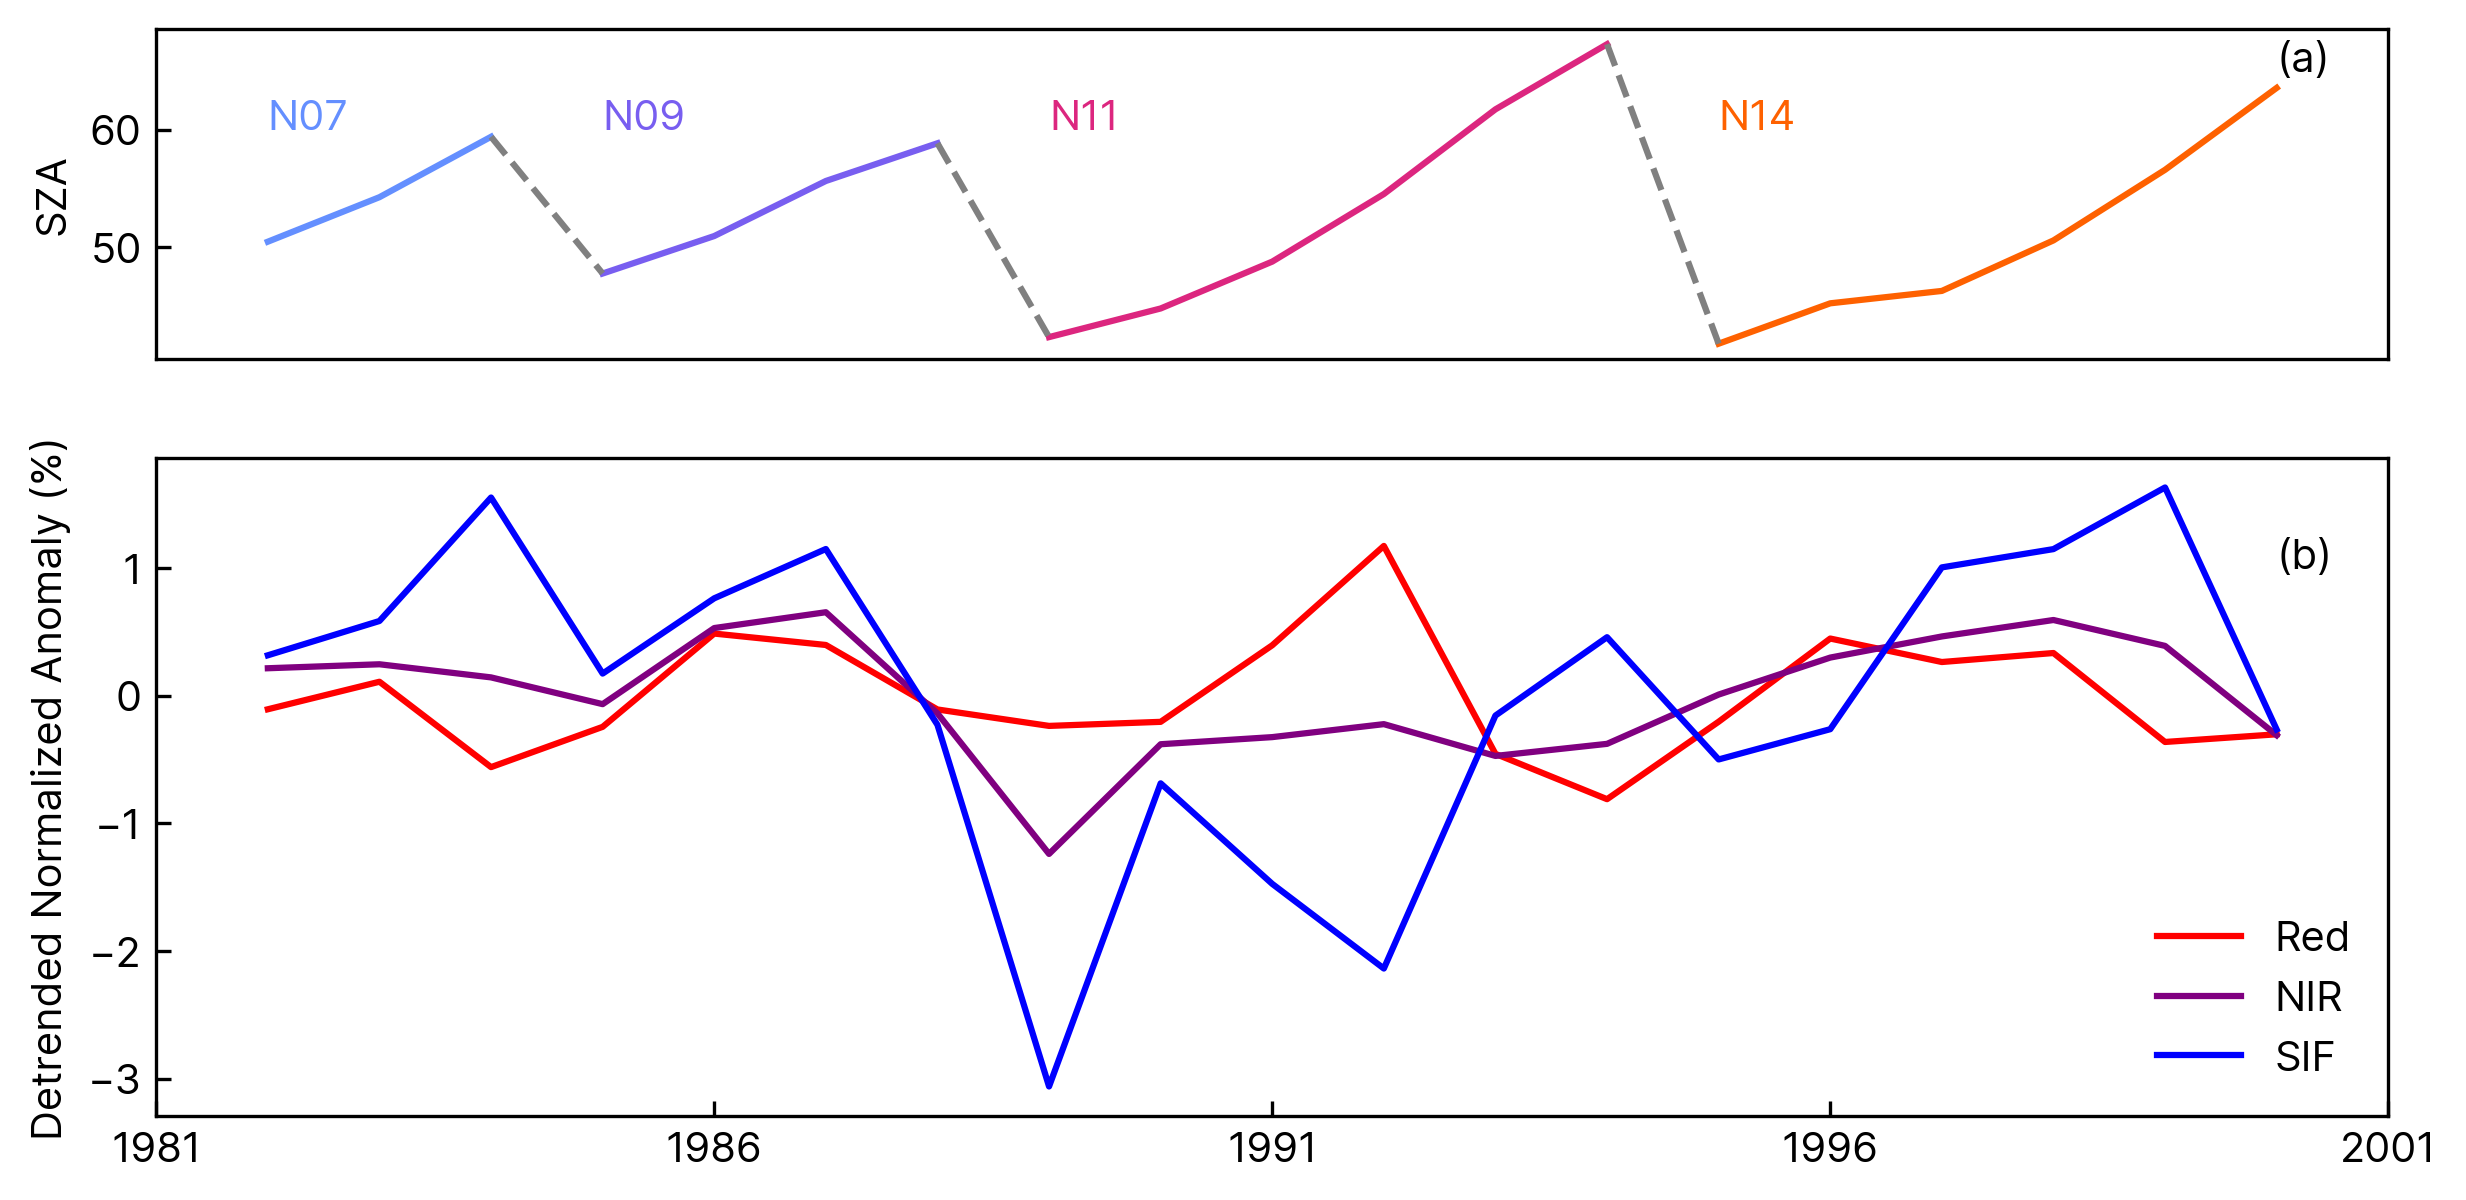

In [58]:
f, (ax1, ax2) = plt.subplots(2, 1,  gridspec_kw={'height_ratios': [1,2]}, figsize=(9.6,4.8), dpi=300)

ax1.plot(np.arange(1982, 2001)[0:3], sza_avhrr_annual_mean_list[0:3], c="#648FFF", label="N07")
ax1.text(1982, 60, "N07", c="#648FFF")
ax1.plot(np.arange(1982, 2001)[3:7], sza_avhrr_annual_mean_list[3:7], c="#785EF0", label="N09")
ax1.text(1985, 60, "N09", c="#785EF0")
ax1.plot(np.arange(1982, 2001)[7:13], sza_avhrr_annual_mean_list[7:13], c="#DC267F", label="N11")
ax1.text(1989, 60, "N11", c="#DC267F")
ax1.plot(np.arange(1982, 2001)[13:19], sza_avhrr_annual_mean_list[13:19], c="#FE6100", label="N14")
ax1.text(1995, 60, "N14", c="#FE6100")
ax1.plot(np.arange(1982, 2001)[2:4], sza_avhrr_annual_mean_list[2:4], c="grey", linestyle="--")
ax1.plot(np.arange(1982, 2001)[6:8], sza_avhrr_annual_mean_list[6:8], c="grey", linestyle="--")
ax1.plot(np.arange(1982, 2001)[12:14], sza_avhrr_annual_mean_list[12:14], c="grey", linestyle="--")

ax1.set_xticks([])
ax1.set_ylabel("SZA")
ax2.plot(np.arange(1982, 2001), red_avhrr_annual_normalized_anomaly_detrend * 100, c="red", label="Red")
ax2.plot(np.arange(1982, 2001), nir_avhrr_annual_normalized_anomaly_detrend * 100, c="purple", label="NIR")
ax2.plot(np.arange(1982, 2001), sif_avhrr_annual_normalized_anomaly_detrend * 100, c="blue", label="SIF")

ax2.set_xticks([1981, 1986, 1991, 1996, 2001], ["1981", "1986", "1991", "1996", "2001"])
ax2.legend(frameon=False, loc="lower right")
ax1.set_xlim(1981,2001)
ax2.set_xlim(1981,2001)
ax1.text(2000, 65, "(a)")
ax2.text(2000, 1, "(b)")

ax2.set_ylabel("Detrended Normalized Anomaly (%)", fontsize=10)
plt.savefig("./figs/Global_SZA_Reflectance_Anomaly.png")

In [ ]:
red_avhrr_spatial_da = xr.DataArray(red_avhrr_spatial_array, dims=["time", "lat", "lon"], coords={"time":np.arange(1982, 2001),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
red_avhrr_spatial_time_da = xr.DataArray(np.stack([np.full((360,720), i).astype(np.float32) for i in red_avhrr_spatial_da.time]), dims=["time", "lat", "lon"], coords={"time":red_avhrr_spatial_da.time,
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
nir_avhrr_spatial_da = xr.DataArray(nir_avhrr_spatial_array, dims=["time", "lat", "lon"], coords={"time":np.arange(1982, 2001),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
nir_avhrr_spatial_time_da = xr.DataArray(np.stack([np.full((360,720), i).astype(np.float32) for i in nir_avhrr_spatial_da.time]), dims=["time", "lat", "lon"], coords={"time":red_avhrr_spatial_da.time,
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
sif_avhrr_spatial_da = xr.DataArray(sif_avhrr_spatial_array, dims=["time", "lat", "lon"], coords={"time":np.arange(1982, 2001),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
sif_avhrr_spatial_time_da = xr.DataArray(np.stack([np.full((360,720), i).astype(np.float32) for i in sif_avhrr_spatial_da.time]), dims=["time", "lat", "lon"], coords={"time":red_avhrr_spatial_da.time,
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
sza_avhrr_spatial_da = xr.DataArray(sza_avhrr_spatial_array, dims=["time", "lat", "lon"], coords={"time":np.arange(1982, 2001),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
sza_avhrr_spatial_time_da = xr.DataArray(np.stack([np.full((360,720), i).astype(np.float32) for i in sza_avhrr_spatial_da.time]), dims=["time", "lat", "lon"], coords={"time":red_avhrr_spatial_da.time,
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
red_avhrr_cov,red_avhrr_cor,red_avhrr_slope,red_avhrr_intercept,red_avhrr_pval,red_avhrr_stderr = lag_linregress_3D(red_avhrr_spatial_time_da, red_avhrr_spatial_da)
nir_avhrr_cov,nir_avhrr_cor,nir_avhrr_slope,nir_avhrr_intercept,nir_avhrr_pval,nir_avhrr_stderr = lag_linregress_3D(nir_avhrr_spatial_time_da, nir_avhrr_spatial_da)
sif_avhrr_cov,sif_avhrr_cor,sif_avhrr_slope,sif_avhrr_intercept,sif_avhrr_pval,sif_avhrr_stderr = lag_linregress_3D(sif_avhrr_spatial_time_da, sif_avhrr_spatial_da)
sza_avhrr_cov,sza_avhrr_cor,sza_avhrr_slope,sza_avhrr_intercept,sza_avhrr_pval,sza_avhrr_stderr = lag_linregress_3D(sza_avhrr_spatial_time_da, sza_avhrr_spatial_da)



In [34]:
def detrend_raster(data_array, slope_array, intercept_array):
    detrended = deepcopy(data_array)
    for i in range(data_array.shape[0]):
        detrended[i, :, :] = detrended[i, :, :] - ((i + 1982) * slope_array + intercept_array)
    return detrended

In [35]:
red_avhrr_spatial_detrend = detrend_raster(red_avhrr_spatial_array, red_avhrr_slope.values, red_avhrr_intercept.values)
nir_avhrr_spatial_detrend = detrend_raster(nir_avhrr_spatial_array, nir_avhrr_slope.values, nir_avhrr_intercept.values)
sza_avhrr_spatial_detrend = detrend_raster(sza_avhrr_spatial_array, sza_avhrr_slope.values, sza_avhrr_intercept.values)
sif_avhrr_spatial_detrend = detrend_raster(sif_avhrr_spatial_array, sif_avhrr_slope.values, sif_avhrr_intercept.values)

In [248]:
#monthly_idx = np.arange(0, 228).reshape(-1, 12).T
#red_avhrr_spatial_clim = np.nanmean(red_avhrr_spatial_detrend[monthly_idx, :, :], axis=1)
#nir_avhrr_spatial_clim = np.nanmean(nir_avhrr_spatial_detrend[monthly_idx, :, :], axis=1)
#sza_avhrr_spatial_clim = np.nanmean(sza_avhrr_spatial_detrend[monthly_idx, :, :], axis=1)
#sif_avhrr_spatial_clim = np.nanmean(sif_avhrr_spatial_detrend[monthly_idx, :, :], axis=1)

In [249]:
"""
def deseasonalize(data_array, clim_array):
    deseasonalized = deepcopy(data_array)
    for i in range(data_array.shape[0]):
        m = i % 12
        deseasonalized[i, :, :] -= clim_array[m, :, :]
    return deseasonalized
"""

'\ndef deseasonalize(data_array, clim_array):\n    deseasonalized = deepcopy(data_array)\n    for i in range(data_array.shape[0]):\n        m = i % 12\n        deseasonalized[i, :, :] -= clim_array[m, :, :]\n    return deseasonalized\n'

In [187]:
#red_avhrr_spatial_deseasoned = deseasonalize(red_avhrr_spatial_detrend, red_avhrr_spatial_clim)
#nir_avhrr_spatial_deseasoned = deseasonalize(nir_avhrr_spatial_detrend, nir_avhrr_spatial_clim)
#sza_avhrr_spatial_deseasoned = deseasonalize(sza_avhrr_spatial_detrend, sza_avhrr_spatial_clim)
#sif_avhrr_spatial_deseasoned = deseasonalize(sif_avhrr_spatial_detrend, sif_avhrr_spatial_clim)

In [36]:
red_avhrr_spatial_detrend_da = xr.DataArray(red_avhrr_spatial_detrend, dims=["time", "lat", "lon"], coords={"time":np.arange(1982,2001),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})

nir_avhrr_spatial_detrend_da = xr.DataArray(nir_avhrr_spatial_detrend, dims=["time", "lat", "lon"], coords={"time":np.arange(1982,2001),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})

sza_avhrr_spatial_detrend_da = xr.DataArray(sza_avhrr_spatial_detrend, dims=["time", "lat", "lon"], coords={"time":np.arange(1982,2001),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
sif_avhrr_spatial_detrend_da = xr.DataArray(sif_avhrr_spatial_detrend, dims=["time", "lat", "lon"], coords={"time":np.arange(1982,2001),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})

In [99]:
def plot_pattern(fig, ax1, ax2, data_mat, p_val, text_str, cor=False, bound_norm_list=None, bound_norm_tick=None, bound_norm_tick_label=None, lat_xlim=None, lat_norm_tick=None, lat_norm_tick_label=None):
    count_too_small = 720 - np.sum(np.isnan(data_mat), axis=1) < 25
    
    if not cor or bound_norm_list is not None:
        data_mat_mean = np.nanmean(data_mat, axis=1)
        lower_ribbon = (data_mat_mean-np.nanstd(data_mat, axis=1))
        upper_ribbon = (data_mat_mean+np.nanstd(data_mat, axis=1))
    else:
        data_mat_mean = np.nanmean(data_mat, axis=1)
        lower_ribbon = (data_mat_mean-np.nanstd(data_mat, axis=1))
        upper_ribbon = (data_mat_mean+np.nanstd(data_mat, axis=1))
        
        data_mat_mean[count_too_small] = np.nan
        lower_ribbon[count_too_small] = np.nan
        upper_ribbon[count_too_small] = np.nan
        

    ax1.fill_betweenx(np.flip(np.arange(-89.75,90, 0.5)),
                      lower_ribbon, upper_ribbon, color="lightgray")
    ax1.plot(data_mat_mean, np.flip(np.arange(-89.75,90, 0.5)), color="darkmagenta")
    
    if not cor:
        if lat_xlim is not None:
            ax1.set_xlim(lat_xlim[0], lat_xlim[1])
            ax1.set_xticks(lat_norm_tick, lat_norm_tick_label)
        else:
            ax1.set_xlim(-0.015, 0.015)
            ax1.set_xticks([-0.01, 0, 0.01], ['-0.01', '0', '0.01'])
        ax1.set_yticks([90, 60, 30, 0, -30, -60, -90], ['90$^{\circ}N$', '60$^{\circ}N$', '30$^{\circ}N$', '0$^{\circ}$', '30$^{\circ}S$', '60$^{\circ}S$', '90$^{\circ}S$'])
        ax1.set_ylim(-90, 90)

    else:
        ax1.set_xlim(-0.04,0.04)
        ax1.set_xticks([-0.03, 0.03], ['-0.03', '0.03'])
        ax1.set_yticks([90, 60, 30, 0, -30, -60, -90], ['90$^{\circ}N$', '60$^{\circ}N$', '30$^{\circ}N$', '0$^{\circ}$', '30$^{\circ}S$', '60$^{\circ}S$', '90$^{\circ}S$'])
        ax1.set_ylim(-90, 90)
        

    if not cor:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkmagenta","white", "darkgreen"])
        if bound_norm_list is not None:
            norm=matplotlib.colors.BoundaryNorm(bound_norm_list, matplotlib.cm.viridis.N, extend='max')
            im2=ax2.imshow(data_mat, transform=ccrs.PlateCarree(), aspect='auto', extent=[-180,180,-90,90],interpolation="none", norm=norm, cmap="viridis")
            cbar = fig.colorbar(im2, ax=ax2, orientation="vertical", fraction=0.027, ticks=bound_norm_tick)
            cbar.ax.set_yticklabels(bound_norm_tick_label)
        else:
            norm=matplotlib.colors.BoundaryNorm([-0.03, -0.025, -0.02, -0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03], matplotlib.cm.hot.N, extend='both')
            im2=ax2.imshow(data_mat * 10, transform=ccrs.PlateCarree(), aspect='auto', extent=[-180,180,-90,90],interpolation="none", norm=norm, cmap=cmap)
            cbar = fig.colorbar(im2, ax=ax2, orientation="vertical", fraction=0.027, ticks=[-0.03,-0.02, -0.01, 0, 0.01, 0.02, 0.03])
            cbar.ax.set_yticklabels(['-0.03', '-0.02', '-0.01', '0', '0.01', '0.02', '0.03'])
        
    else:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","yellow", "darkred"])
        norm=matplotlib.colors.BoundaryNorm([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1], matplotlib.cm.hot.N)
        im2=ax2.imshow(data_mat, transform=ccrs.PlateCarree(), aspect='auto', extent=[-180,180,-90,90],interpolation="none", cmap="bwr", norm=norm)
        cbar = fig.colorbar(im2, ax=ax2, orientation="vertical", fraction=0.027, ticks=[-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
        cbar.ax.set_yticklabels(["-1", "-0.8", "-0.6", "-0.4", "-0.2", "0", "0.2", "0.4", "0.6", "0.8", "1"])
        
    ax2.add_feature(cartopy.feature.OCEAN, zorder=0, color="white")
    ax2.coastlines()
    gl=ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.right_labels=False
    gl.top_labels=False
    gl.left_labels=False

    if not (p_val is None):
        ax2.contourf(np.arange(-179.75, 180, 0.5), np.flip(np.arange(-89.75,90, 0.5)), p_val < 0.05, levels=1,
                          colors="white", hatches=['', '...'] , extend='neither', alpha=0)
    ax2.text(-180, 95, text_str, fontsize=25)

In [ ]:
red_sza_avhrr_cov,red_sza_avhrr_cor,red_sza_avhrr_slope,red_sza_avhrr_intercept,red_sza_avhrr_pval,red_sza_avhrr_stderr = lag_linregress_3D(red_avhrr_spatial_detrend_da, sza_avhrr_spatial_detrend_da)
nir_sza_avhrr_cov,nir_sza_avhrr_cor,nir_sza_avhrr_slope,nir_sza_avhrr_intercept,nir_sza_avhrr_pval,nir_sza_avhrr_stderr = lag_linregress_3D(nir_avhrr_spatial_detrend_da, sza_avhrr_spatial_detrend_da)
sif_sza_avhrr_cov,sif_sza_avhrr_cor,sif_sza_avhrr_slope,sif_sza_avhrr_intercept,sif_sza_avhrr_pval,sif_sza_avhrr_stderr = lag_linregress_3D(sif_avhrr_spatial_detrend_da, sza_avhrr_spatial_detrend_da)

In [39]:
LOW_SIF_MASK = np.load("../../data/processed/low_sif_mask_0.03.npy")

red_sza_avhrr_cov_masked = copy(red_sza_avhrr_cov.values)
red_sza_avhrr_cov_masked[LOW_SIF_MASK] = np.nan

nir_sza_avhrr_cov_masked = copy(nir_sza_avhrr_cov.values)
nir_sza_avhrr_cov_masked[LOW_SIF_MASK] = np.nan

sif_sza_avhrr_cov_masked= copy(sif_sza_avhrr_cov.values)
sif_sza_avhrr_cov_masked[LOW_SIF_MASK] = np.nan

red_sza_avhrr_pval_masked = copy(red_sza_avhrr_pval.values)
red_sza_avhrr_pval_masked[LOW_SIF_MASK] = np.nan

nir_sza_avhrr_pval_masked = copy(nir_sza_avhrr_pval.values)
nir_sza_avhrr_pval_masked[LOW_SIF_MASK] = np.nan

sif_sza_avhrr_pval_masked = copy(sif_sza_avhrr_pval.values)
sif_sza_avhrr_pval_masked[LOW_SIF_MASK] = np.nan

/tmp/ipykernel_2012682/3890633965.py:3: RuntimeWarning: Mean of empty slice
  sza_coeff_variation = np.nanstd(sza_avhrr_spatial_array, axis=0) / np.nanmean(sza_avhrr_spatial_array, axis=0)
/tmp/ipykernel_2012682/3167144657.py:9: RuntimeWarning: Mean of empty slice
  data_mat_mean = np.nanmean(data_mat, axis=1)
/tmp/ipykernel_2012682/3167144657.py:5: RuntimeWarning: Mean of empty slice
  data_mat_mean = np.nanmean(data_mat, axis=1)


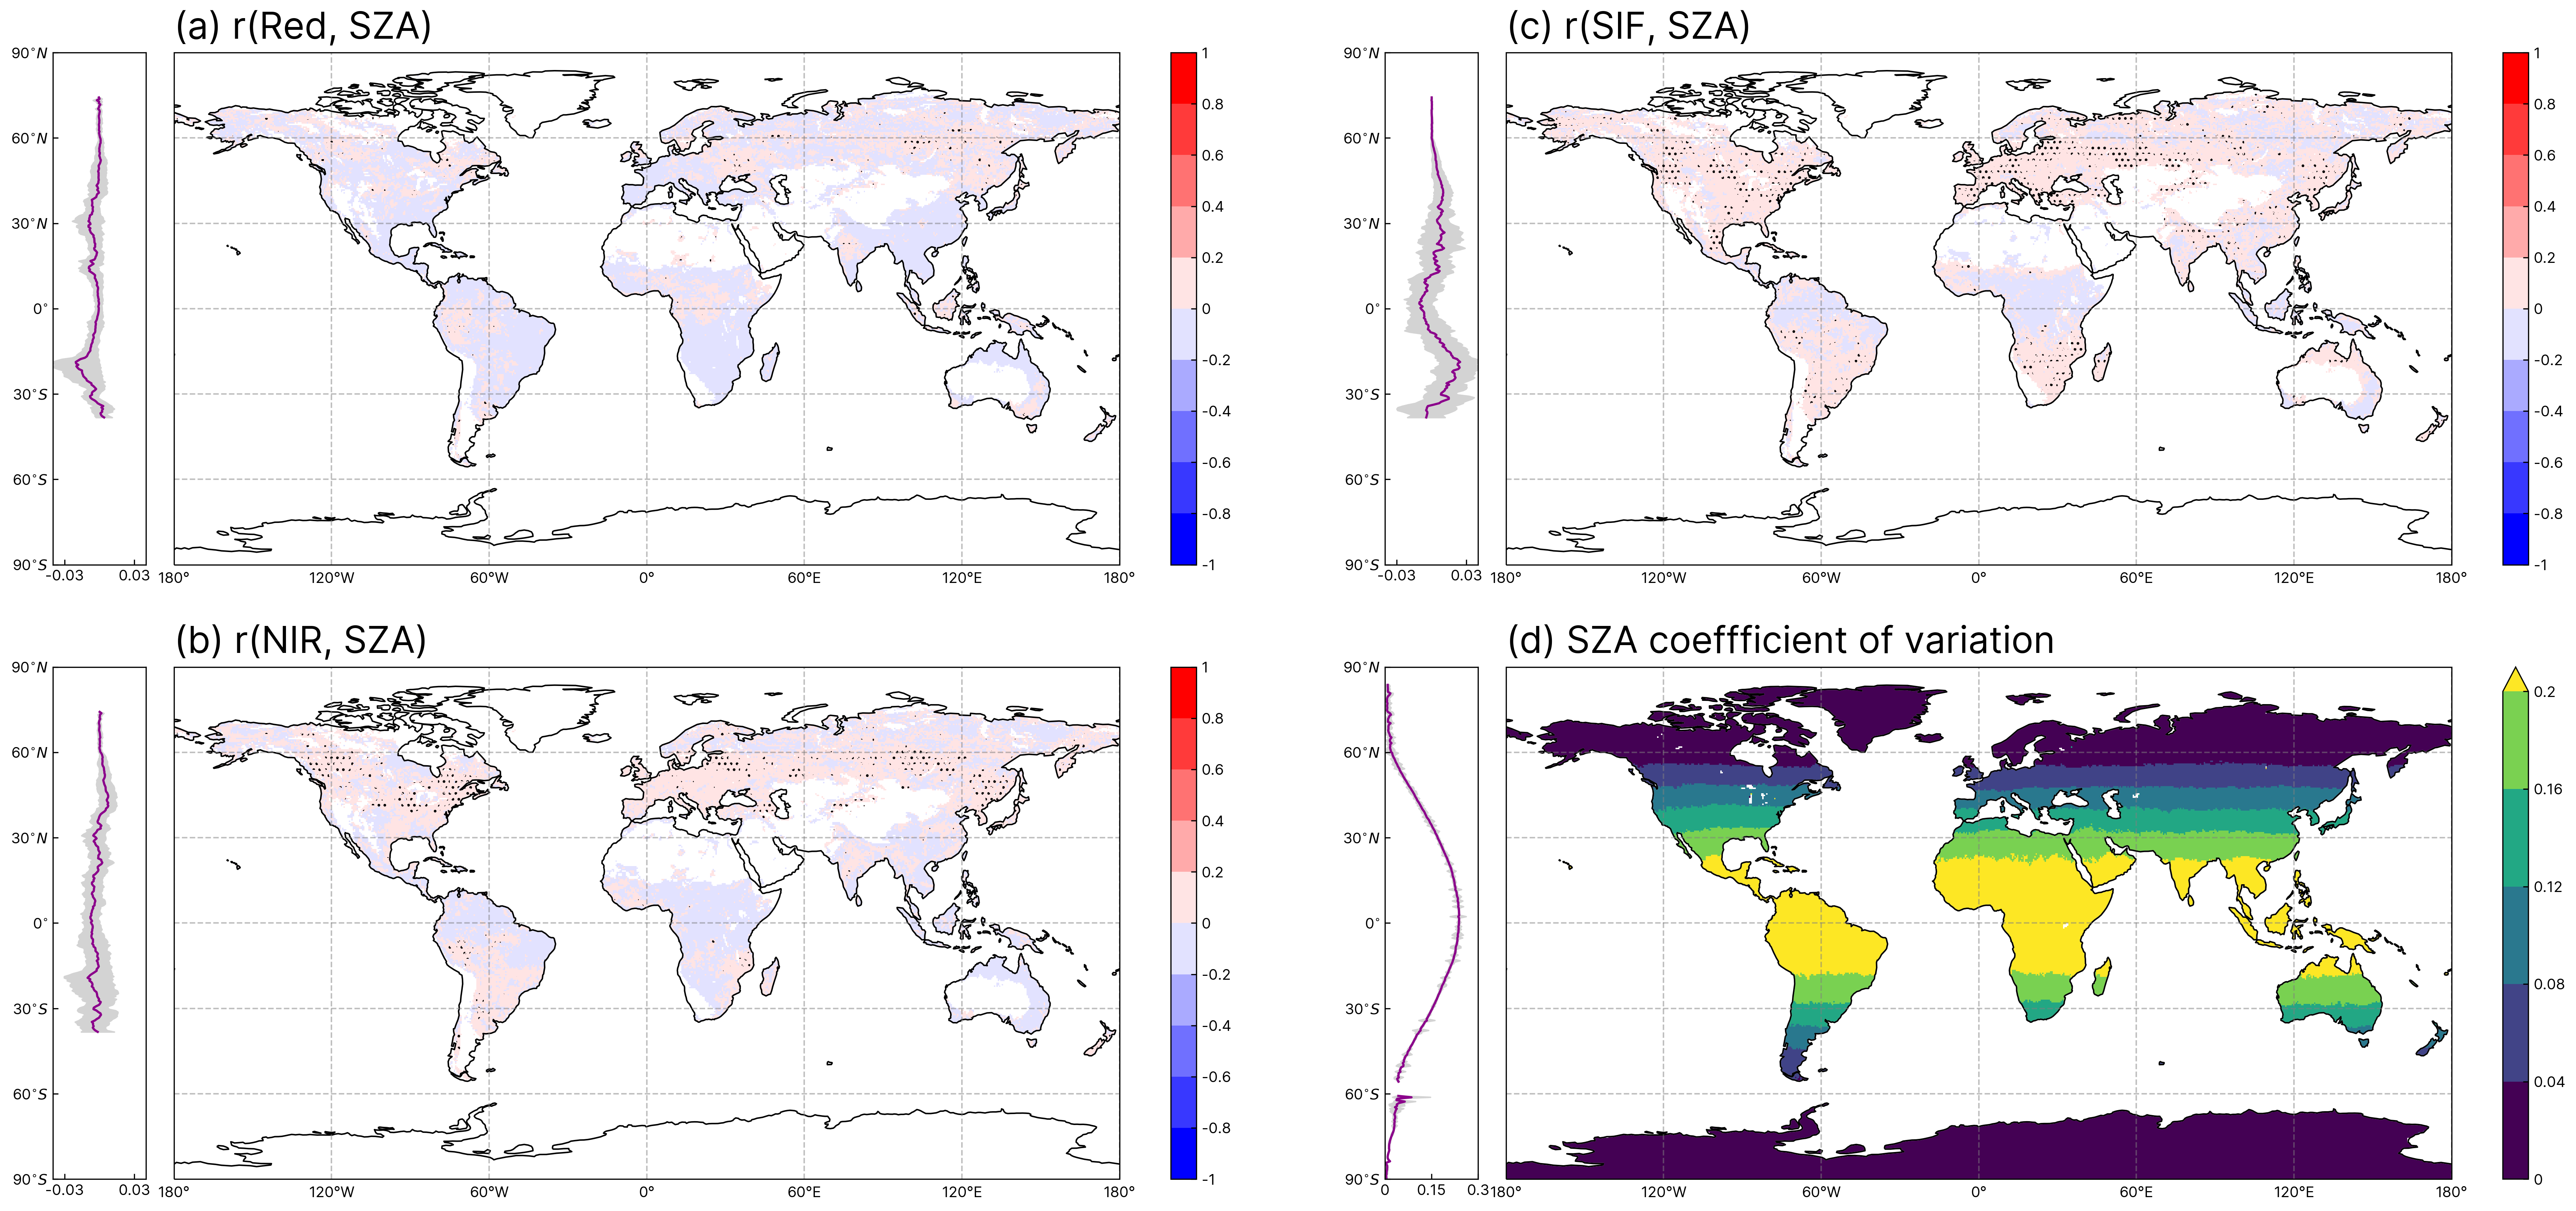

In [101]:
from matplotlib import gridspec

sza_coeff_variation = np.nanstd(sza_avhrr_spatial_array, axis=0) / np.nanmean(sza_avhrr_spatial_array, axis=0)

f = plt.figure(figsize=(25,14), dpi=300)
gs1 = gridspec.GridSpec(2, 2, width_ratios=[0.2, 2.2],
                       height_ratios=[1, 1, ], wspace=0.02)
gs1.update(left=0.05, right=0.48, wspace=0.05)

ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[0, 1], projection=ccrs.PlateCarree())
plot_pattern(f, ax1, ax2, red_sza_avhrr_cov_masked, red_sza_avhrr_pval_masked, "(a) r(Red, SZA)", True)


ax3 = plt.subplot(gs1[1, 0])
ax4 = plt.subplot(gs1[1, 1], projection=ccrs.PlateCarree())

plot_pattern(f, ax3, ax4, nir_sza_avhrr_cov_masked, nir_sza_avhrr_pval_masked, "(b) r(NIR, SZA)", True)

gs2 = gridspec.GridSpec(2, 2, width_ratios=[0.2, 2.2],
                       height_ratios=[1,1], wspace=0.02)
gs2.update(left=0.55, right=0.98, wspace=0.05)

ax5 = plt.subplot(gs2[0, 0])
ax6 = plt.subplot(gs2[0, 1], projection=ccrs.PlateCarree())

plot_pattern(f, ax5, ax6, sif_sza_avhrr_cov_masked, sif_sza_avhrr_pval_masked, "(c) r(SIF, SZA)", True)

ax7 = plt.subplot(gs2[1, 0])
ax8 = plt.subplot(gs2[1,1], projection=ccrs.PlateCarree())

plot_pattern(f, ax7, ax8, sza_coeff_variation, None, "(d) SZA coeffficient of variation",
             False, bound_norm_list=[0, 0.04, 0.08, 0.12, 0.16, 0.2], bound_norm_tick=[0, 0.04, 0.08, 0.12, 0.16, 0.2],
             bound_norm_tick_label=["0", "0.04", "0.08", "0.12", "0.16", "0.2"], lat_xlim=[0, 0.3], lat_norm_tick=[0, 0.15, 0.3], lat_norm_tick_label=["0", "0.15", "0.3"])


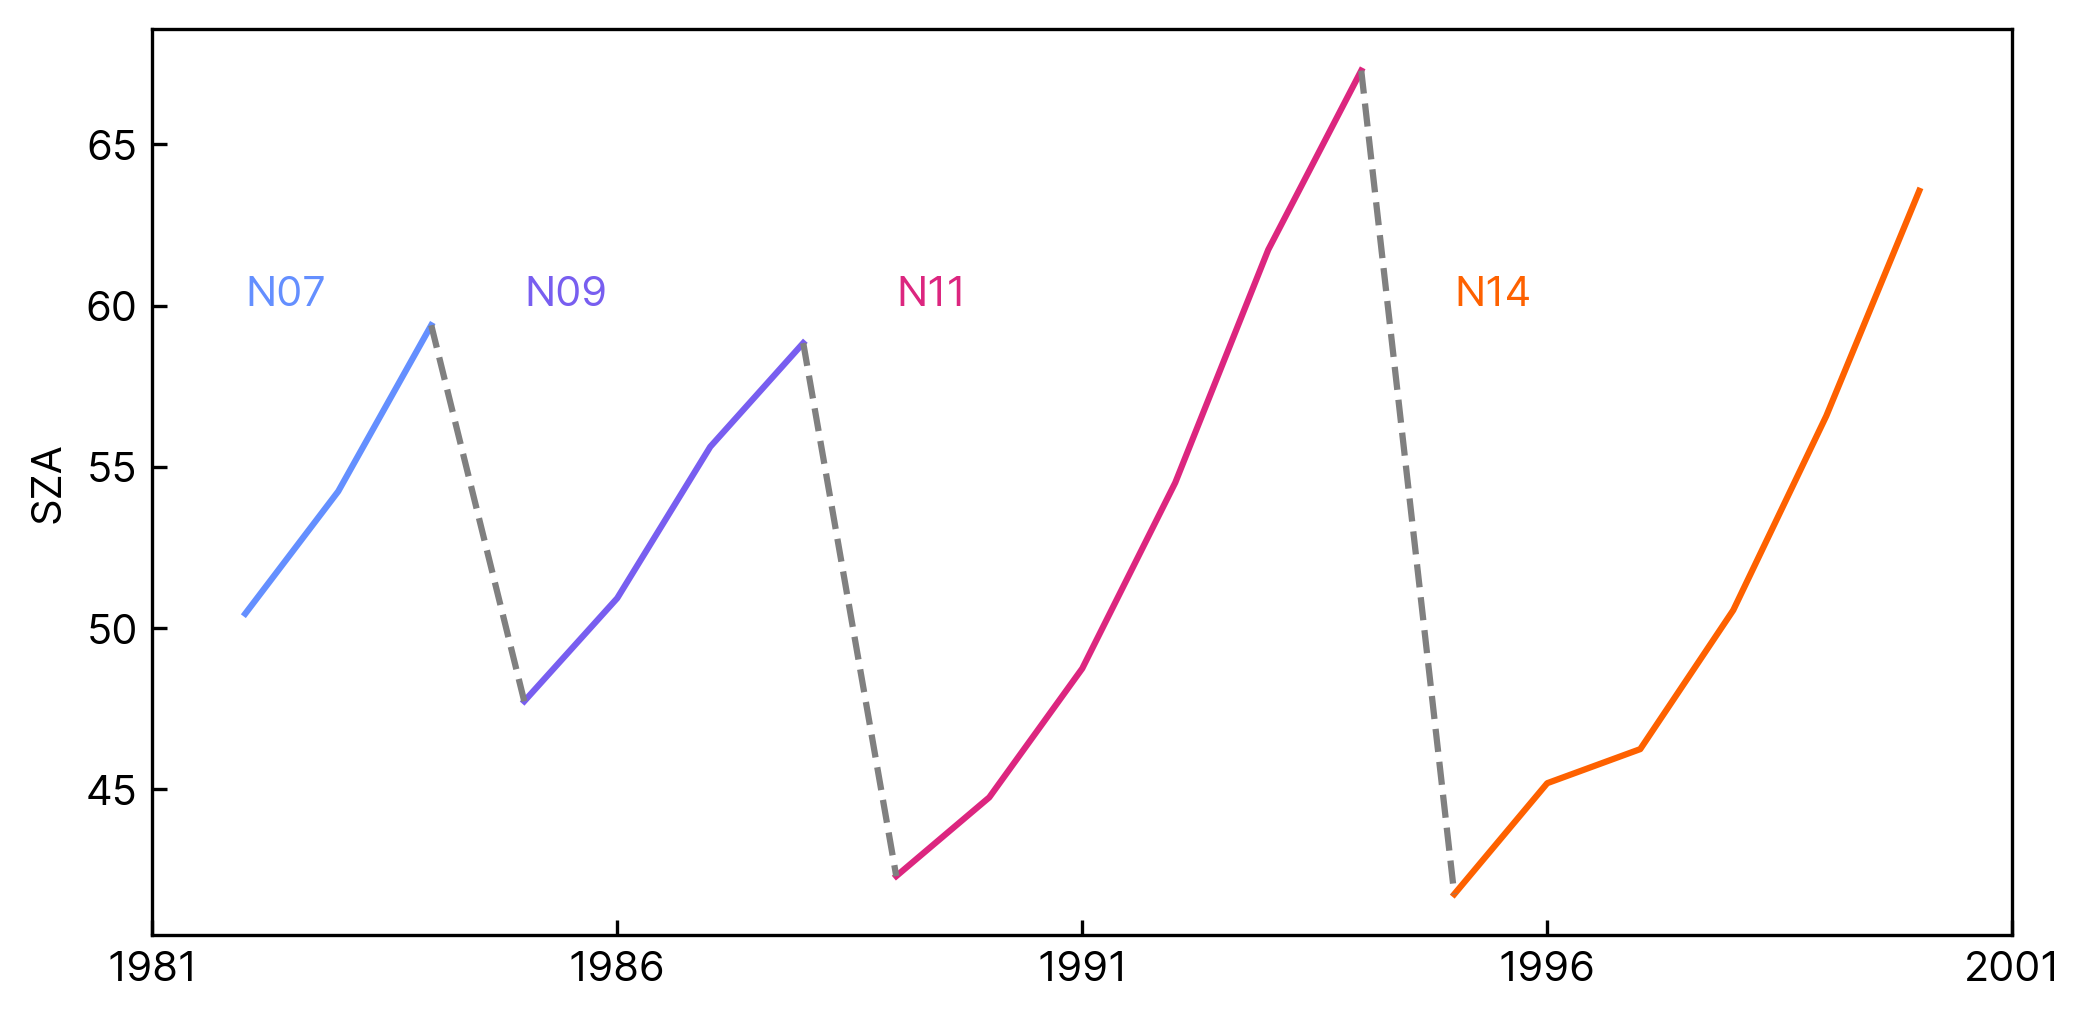

In [86]:
plt.figure(figsize=(8,4), dpi=300)
plt.plot(np.arange(1982, 2001)[0:3], sza_avhrr_annual_mean_list[0:3], c="#648FFF", label="N07")
plt.text(1982, 60, "N07", c="#648FFF")
plt.plot(np.arange(1982, 2001)[3:7], sza_avhrr_annual_mean_list[3:7], c="#785EF0", label="N09")
plt.text(1985, 60, "N09", c="#785EF0")
plt.plot(np.arange(1982, 2001)[7:13], sza_avhrr_annual_mean_list[7:13], c="#DC267F", label="N11")
plt.text(1989, 60, "N11", c="#DC267F")
plt.plot(np.arange(1982, 2001)[13:19], sza_avhrr_annual_mean_list[13:19], c="#FE6100", label="N14")
plt.text(1995, 60, "N14", c="#FE6100")
plt.plot(np.arange(1982, 2001)[2:4], sza_avhrr_annual_mean_list[2:4], c="grey", linestyle="--")
plt.plot(np.arange(1982, 2001)[6:8], sza_avhrr_annual_mean_list[6:8], c="grey", linestyle="--")
plt.plot(np.arange(1982, 2001)[12:14], sza_avhrr_annual_mean_list[12:14], c="grey", linestyle="--")

plt.ylabel("SZA")
plt.xticks([1981, 1986, 1991, 1996, 2001], ["1981", "1986", "1991", "1996", "2001"])
plt.show()